# TP4a - Compression, Entropy

#### Stella Douka, Guillaume Charpiat

### Introduction

In this TP we are interested in comparing different compression methods and making a connection between compression and entropy. Given text samples of different complexity and structure we will use compression algorithms and compare the lengths of the compressed sequences. We will then use entropy, as estimated by Markov chain models of different orders, to obtain insights about text compression.

In [1]:
import numpy as np
import gzip, bz2, lzma

### Compression techniques

#### Lempel-Ziv (LZ77)
Lempel-Ziv is a dictionary based lossless compression technique. The main idea is to replace repeated substrings with references to their earlier occurencies. It works like a sliding window in the sense that instead of rewritting phrases with repeated patterns it encodes them as (distance, length). 

For example if we have the string "abababc" we proceed as follows:
- We see the substring characters "ab" which are new and consider them new literals. 
- Then we see "ab" again at a distance 2 with a length of 2. This is encoded as (2,2). 
- We repeat the process and find (4,2). 
- Then we see the character "c" which is new and we add it as a literal. The result is: 
$$ [ a, b, (2,2), (4,2), c] $$

#### Huffman Tree
The main idea here is to assign shorter encodings to more frequent symbols. This way we create shorter encodings. The length of each encoding is entropy-based 
$$ l = \ulcorner - log_2(p_i) \urcorner $$
and is built using a binary tree, thus minimizing the expected code length.

#### Range Coding / Arithmetic Coding
We can consider this as a near-entropy encoding. It encodes a whole substring as a number in $[0,1)$. It is based on cumulative probability of the characters and it is actually very close to the Shannon limit.

#### Burrows-Wheeler Transform (BWT)
This is a reordering technique that permutes the string to produce patterns of similar symbols. Thus we have a reordered string where sequences of the same character are frequent. It is not a compression on itself but it is used in combination with other methods to produce more "compressible" data.

#### Move-to-Front (MTF)
This technique, similar to BWT, is producing more compressible data using symbol ranking. It encodes characters by their position in a moving list of recent symbols. This way frequent symbols become small numbers. The result is highly compressible with entropy-based encoders.

### Compression algorithms
The most famous compression algorithms use combinations of the techniques described above. 
- The most popular one, `gzip`, uses LZ77 to find repetitions and Huffman to encode symbols. 
- Another algorithm, `bz2`, uses BWT to cluster similar characters together, then MTF to reduce the symbols' variation and finally Huffman. 
- `lzma` uses a LZ77 with a very large dictionary to find long matches and range coding to do near-entropy based encoding.

-----------------------

### Practical questions

1. Generate different types of text data

    Create different types of text files:
    - Structured text (highly repetitive, predictable pattern).
    - Semi-structured text (some randomness, but still some patterns).
    - Random text (completely unpredictable).
    - Real text.


2. Which of the samples do you expect to be well compressed or not, and why? Explain your opinion. (Marks will be given based on logical explanations, not on correct answers!)

Answer:

Expected compressibility:

"structured" should be compressed extremely well because it consists of a single short phrase repeated thousands of times; LZ77 will turn most of it into tiny back‑references and Huffman/Rangecoding will encode the few literals cheaply.

"semi_structured" should still be compressed, but not as dramatically. It keeps a clear underlying pattern, so compressors can exploit repeats, yet the 10% random mutations break some matches and increase entropy.

"random" is expected to be compressed poorly; every byte is nearly independent so there are no useful repeats and the empirical entropy is close to 8 bits/byte. Compressors may even add slight overhead.

"real" has substantial redundancy (common words, grammatical structure) because it's natural language so we anticipate moderate compression - not as good as the synthetic structured data but definitely far better than the random sample.

In [3]:
np.random.seed(0)

# TODO: Generate structured text (e.g., repeating patterns)
structured_text = ("ABC " * 10_000).strip()

# TODO: Generate semi-structured text (pattern with some randomness)
base_chars = list("".join(["ABCDEF" for _ in range(5_000)]))
num_mutations = int(len(base_chars) * 0.10)
for _ in range(num_mutations):
    idx = np.random.randint(0, len(base_chars))
    base_chars[idx] = chr(np.random.randint(65, 91))  # random capital letter
semi_structured_text = "".join(base_chars)

# TODO: Generate random text (completely unpredictable)
random_text = "".join(chr(np.random.randint(65, 91)) for _ in range(30_000))

# TODO: Provide real text
real_text = (
    """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she
had peeped into the book her sister was reading, but it had no pictures or conversations in it, \"and what is the use of a
book,\" thought Alice \"without pictures or conversations?\"  
""".strip()
    * 200
)

3. Compress the text using various compression algorithms (gzip, bzip2, lzma etc..). Measure and record the compressed size in bytes.

4. Were your assumptions correct? Explain the results you obtained.
5. How do the compression algorithms compare to each other? Which ones perform the best and why?

In [4]:
# TODO: Compress the text with  different compression algorithms
# ...

def compress_gzip(data: bytes, compresslevel: int = 9) -> int:
    return len(gzip.compress(data, compresslevel=compresslevel))

def compress_bz2(data: bytes, compresslevel: int = 9) -> int:
    return len(bz2.compress(data, compresslevel))

def compress_lzma(data: bytes, preset: int = 9) -> int:
    return len(lzma.compress(data, preset=preset))

6. Estimate the entropy using Markovian models
   - Use the Markov chain models you coded for TP2. If you had not completed it correctly you can do it now or find a working solution online.
   - Compute entropy estimates for orders up to 3 for each one of the text samples. (Hint: entropy should decrease with the order!)
    

7. Compare ZIP compression with entropy estimates
   - Compare ZIP-compressed sizes with entropy-based expected compressed sizes.
   - Plot a table or graph showing ZIP size vs. entropy estimates for different Markov chain orders.
   - Analyze and answer the discussion questions below.



In [7]:
# TODO: Add the implementation of Markov chains here
from collections import Counter, defaultdict
import math

def markov_entropy(text: str, order: int = 0) -> float:
    if order < 0:
        raise ValueError("Order must be >= 0")
    n = len(text)
    if n <= order:
        return 0.0

    if order == 0:
        counts = Counter(text)
        total = n
        return -sum(c / total * math.log2(c / total) for c in counts.values())

    context_counts = defaultdict(int)
    joint_counts = defaultdict(int)

    for i in range(n - order):
        context = text[i : i + order]
        next_char = text[i + order]
        context_counts[context] += 1
        joint_counts[context + next_char] += 1

    H = 0.0
    for i in range(n - order):
        context = text[i : i + order]
        next_char = text[i + order]
        p = joint_counts[context + next_char] / context_counts[context]
        H -= math.log2(p)
    return H / (n - order)

In [8]:
# TODO: Estimate entropy with Markov chains of different orders
samples = {
    "structured": structured_text,
    "semi_structured": semi_structured_text,
    "random": random_text,
    "real": real_text,
}

entropy_estimates = {
    name: {f"order_{k}": markov_entropy(txt, k) for k in range(4)} for name, txt in samples.items()
}

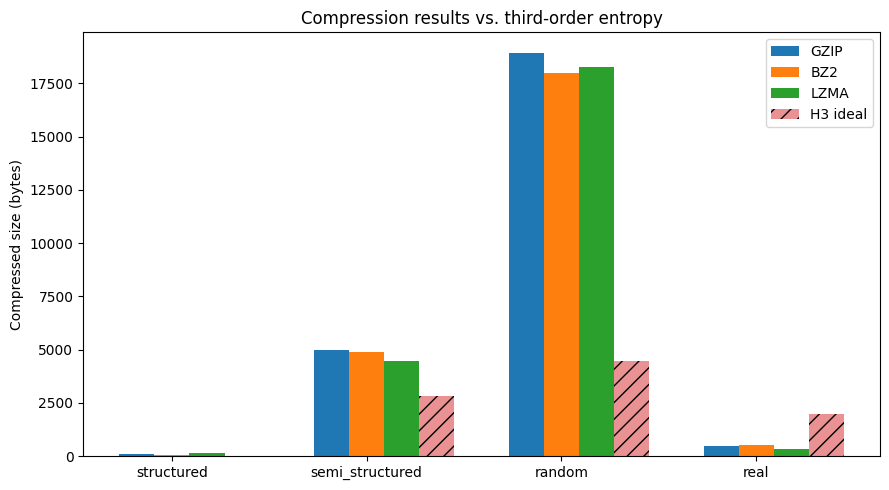

In [10]:
# TODO: Plot results comparing ZIP size vs. entropy estimates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 5))
orders = ["order_0", "order_1", "order_2", "order_3"]
x = np.arange(len(samples))
width = 0.18

def _to_bytes(s: str) -> bytes:
    return s.encode("utf‑8")

compressed_sizes = {}
for name, txt in samples.items():
    b = _to_bytes(txt)
    compressed_sizes[name] = {
        "raw": len(b),
        "gzip": compress_gzip(b),
        "bz2": compress_bz2(b),
        "lzma": compress_lzma(b),
    }

for i, alg in enumerate(["gzip", "bz2", "lzma"]):
    sz = [compressed_sizes[s][alg] for s in samples]
    ax.bar(x + (i - 1) * width, sz, width, label=alg.upper())
    
ideal_sizes = {
    name: {k: int(est * len(samples[name]) / 8) for k, est in orders.items()}
    for name, orders in entropy_estimates.items()
}

# Add entropy bars (order‑3 as reference)
ent_sz = [ideal_sizes[s]["order_3"] for s in samples]
ax.bar(x + 2 * width, ent_sz, width, label="H3 ideal", alpha=0.5, hatch="//")

ax.set_xticks(x)
ax.set_xticklabels(samples.keys())
ax.set_ylabel("Compressed size (bytes)")
ax.set_title("Compression results vs. third‑order entropy")
ax.legend()
plt.tight_layout()
plt.show()

### Theoretical questions

8. Which type of text (structured, semi-structured, or random) was compressed the most on average? Why?

9. How does ZIP compression compare to entropy estimates?

10. Are there cases where ZIP compression is more efficient than entropy estimates? Why?

11. What are the limitations of using entropy as a compression predictor?

Answers:

8. Structured, because its high redundancy lets dictionary methods map long repeats to very short references and entropy of order‑0 is low.

9. The comparison depends on how much long‑range repetition a text contains. 
For structured & “real” (repeated paragraph) all the compressors end up below the third‑order entropy bound, because a single back‑reference can cover dozens or hundreds of bytes – far beyond the 3‑symbol context H3 considers.
For semi‑structured the sizes fall above the H3 bound (≈ 2.8 kB) but still well below the raw file, landing close to what an order‑1/2 model predicts. For "random" the compressors achieve little. The results stay near the raw size and lie well above every entropy estimate.

10. Yes — whenever text contains very long verbatim repeats that a low‑order Markov model can't capture. Both the synthetic structured sample and the “real” corpus (one paragraph duplicated) compress beyond the H3 ideal because LZ77 replaces each repeat with a tiny pointer, whereas the entropy model still counts every character in the repeat. In contrast, for "random" or lightly‑structured data compressors stay above the entropy bound.

11. Estimates depend on sample size and suffer from sparse contexts. Also Markov models assume limited memory k whereas real data may have long‑range structure. Another limitation is that they ignore implementation overhead (headers, alignment, dictionary resets). Moreover, they operate at symbol level; switching to words or UTF‑8 code‑points changes values. Hence entropy is a lower bound, not a guarantee.